# VAD Model 을 감정 사전에 적용해 시각화
KOSAC 감정사전: http://word.snu.ac.kr/kosac/lexicon.php

VAD Model: 감정을 세가지 차원-Valence, Arousal, Dominance-으로 표현해 감정마다 다른 극성, 강도, 적극성을 표현했다.

In [38]:
import pandas as pd
import random
import nltk

nltk.download('punkt')

import numpy as np
from numpy import dot
from sklearn.manifold import TSNE
import gensim 
import gensim.models as g
import nltk
from gensim.models import Word2Vec
from nltk.tokenize import RegexpTokenizer
from nltk.tokenize import word_tokenize, WordPunctTokenizer, TreebankWordTokenizer, RegexpTokenizer, sent_tokenize

[nltk_data] Downloading package punkt to /Users/lifeofpy/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [39]:
real_emotional_dict = pd.read_excel('emotional_dict.xlsx')
real_emotional_dict.drop(['Unnamed: 0'], axis=1, inplace=True)

In [40]:
real_emotional_dict = real_emotional_dict.fillna('-')

real_emotional_dict

,ngram,similar_words,max.value,max.prop,max.arousal,max.dominance
0,가깝,친밀,NEG,-0.5,0.642,-0.754
1,가슴,사랑,POS,0.4,-0.207,-0.890
2,각별,"그리, 그립",POS,1.0,-0.826,0.348
3,감,-,NEG,-0.5,-0.843,-0.755
4,감동,"감격, 감정",POS,1.0,0.818,0.648
...,...,...,...,...,...,...
104,환영,-,POS,1.0,0.070,-0.230
105,환희,-,POS,1.0,-0.720,-0.118
106,황홀,-,POS,1.0,0.237,-0.822
107,흠모,-,POS,1.0,0.506,-0.961


## 이제 해야하는 것
- 1. 비감정단어를 기준으로 감정 단어(real_emotional_words)가 드러난 댓글을 모은다.
- 2. 댓글 하나에 비감정단어 --- 감정단어 쌍이 있다면, 감정단어를 기준으로 비감정단어에 드러난 감정이 매핑된다.
- 3. 비감정단어를 기준으로, 댓글에 드러난 긍정 또는 부정 감정의 총 점수를 sum 해서 더한다.

   ex. 크리스마스 느낌 나니까 황홀하다. >> POS, 1.0
   
   ex. 크리스마스 노래 들으니까 흥겹네. >> POS, 1.0
   
   ex. 노래 들으니까 이번 크리스마스는 혼자 보낼 것 같아서 슬프네... >> NEG, -1.0 (총 댓글이 3개라고 가정했을 때, 총 점수는 1.0점)
   
   
- 4. 만약에 '너무', '정말', '진짜', '매우', '굉장히' 와 같은 정도를 표현하는 부사가 있을 경우, 강조하는 의미로 해당 점수를 한번 더 더한다.
- 5. 여기서 감정 단어의 경우 ngram 과 유사한 단어를 뽑기 위해 **텍스트 유사도를 활용**하며, 텍스트 유사도가 0.7 이상인 경우, 동의어로 간주해 해당 감정 단어를 선택한다.

In [41]:
# 댓글에 위의 비감정단어가 있으면, 댓글을 따로 저장한다.
# 필요한 라이브러리 불러오기
import os
import warnings
warnings.filterwarnings(action='ignore')
from selenium import webdriver as wd
from webdriver_manager.chrome import ChromeDriverManager
from bs4 import BeautifulSoup
import requests
import time
import random
import re
import pandas as pd
from konlpy.tag import Okt
from collections import Counter
from soynlp.utils import DoublespaceLineCorpus
from soynlp.noun import LRNounExtractor_v2
# from soykeyword.lasso import LassoKeywordExtractor
okt = Okt()

In [42]:
# 불용어 사전 불러오기
with open('stop_words.txt', 'r') as file:
    stop_word = file.readline()
    stop_word = str(stop_word)
    
stop_word = stop_word.replace("\ufeff", '').replace("'", '').replace(",", '').replace('\n', '').replace("’", '').replace("‘", '')
stop_words = stop_word.split()

In [43]:
# 불용어 사전 불러오기
with open('stop_words-nouns.txt', 'r') as file:
    stop_words_nouns = file.readline()
    stop_words_nouns = str(stop_words_nouns)
    
stop_words_nouns = stop_words_nouns.replace("\ufeff", '').replace("'", '').replace(",", '').replace('\n', '').replace("’", '').replace("‘", '')
stop_words_nouns = stop_words_nouns.split()

In [44]:
# 곡 제목, 유튜브 링크가 있는 데이터 프레임(엑셀 파일)을 불러옴
data = pd.read_excel('./melon_music_list_sample.xlsx')
data

,Genre,Song Title,Site Link,Comments
0,NaN,자각몽,https://www.melon.com/song/detail.htm?songId=3...,NaN
1,NaN,Kingdom Come,https://www.melon.com/song/detail.htm?songId=3...,NaN
2,NaN,눈,https://www.melon.com/song/detail.htm?songId=3...,NaN
3,NaN,크리스마스라서,https://www.melon.com/song/detail.htm?songId=5...,NaN


In [45]:
data_lst = data['Site Link'].tolist() # Series to List

In [46]:
all_melon_comments = []

### 크롤링

In [47]:
# 멜론 사이트에서 크롤링하는 코드

for k in range(len(data)):
    
    # 댓글 페이지 개수 구하기
    driver = wd.Chrome(executable_path='/Users/lifeofpy/Desktop/chromedriver')
    page_url = data_lst[k] # url 에 페이지 링크를 하나씩 담아준다
    driver.get(page_url)
    comments = []
    
    html = driver.page_source
    soup = BeautifulSoup(html, 'html.parser')
    pages = soup.find_all('span', {'class': 'd_cmtpgn_srch_cnt'})[0]

    # 일단 추출된 태그를 문자열로 바꾸기
    pages = str(pages)

    # 정규식을 통해 태그에서 숫자(=댓글 개수)만 추출하기
    cmt_num = re.findall('\d+', pages)
    page_num = "".join(cmt_num)
    page_num = int(page_num)
    page_num = page_num//10
        
    # 댓글 페이지마다 바뀔 url 생성
    url = page_url + '#cmtpgn=&pageNo={}&sortType=0&srchType=2&srchWord='
    
    
    for i in range(0, page_num+1):
        link = url.format(i) # {} 안에 들어갈 문자열 포매팅
        driver.get(link)
        driver.implicitly_wait(2)

        html = driver.page_source
        soup = BeautifulSoup(html, 'html.parser')
        comment = soup.find_all('div', {'class': 'd_cmtpgn_cmt_full_contents'})

        for r in comment:
            comments.append(r.get_text().strip())
                    
    # 멜론 댓글 모을 리스트 melon_comments 정의하기
    melon_comments = []
    melon_comments = comments
    
    # 댓글이 모인 comments 리스트에서 필요없는 문자 처리하기
    for j in range(len(melon_comments)):
        if '내용' in melon_comments[j]:
            melon_comments[j] = melon_comments[j].replace('내용', '').replace(' \t\t\t\t\t\t\t\t\t\t', '')
            all_melon_comments.append(melon_comments[j])

### 시각화 방법 1. 특정 비감정단어와 연관있는 댓글만 추출해서, 그 댓글에 포함된 감정단어를 뽑아서 계산 
Brutal-비감정단어가 등장한 댓글에 있는 감정단어로 계산

In [61]:
# 댓글 문장에 나타난 단어 기반으로 VAD 점수 추가하는 함수 생성
def make_score_board(x_score_board, comments):
    cnt = 0
    for i in range(len(real_emotional_dict)):
        for j in range(len(comments)):
            if real_emotional_dict.iloc[i, 0] in comments[j]: 
                x_score_board['max.prop'] += float(real_emotional_dict['max.prop'][i])
                x_score_board['max.arousal'] += float(real_emotional_dict['max.arousal'][i])
                x_score_board['max.dominance'] += float(real_emotional_dict['max.dominance'][i])
                cnt += 1
            else:
                if real_emotional_dict.iloc[i, 1] != '-':
                    sim_words = real_emotional_dict.iloc[i, 1].split(',')
                    for k in range(len(sim_words)):
                        if sim_words[k] in comments[j]:
                            x_score_board['max.prop'] += float(real_emotional_dict['max.prop'][i])
                            x_score_board['max.arousal'] += float(real_emotional_dict['max.arousal'][i])
                            x_score_board['max.dominance'] += float(real_emotional_dict['max.dominance'][i])
                            cnt += 1
                else:
                    pass
            
    x_score_board['max.prop'] = round(x_score_board['max.prop'] / cnt, 4)
    x_score_board['max.arousal'] = round(x_score_board['max.arousal'] / cnt, 4)
    x_score_board['max.dominance'] = round(x_score_board['max.dominance'] / cnt, 4)
    
    return x_score_board

In [62]:
# 비감정단어를 함수의 input 으로 넣으면 해당 단어가 있는 댓글 리스트를 return 하는 함수               
def extract_cmt(non_emotional_word):
    comments = [] # 해당 비감정단어가 포함된 comments 모음의 경우, 지역변수로 정의해야함
    for i in range(len(all_melon_comments)):
        if non_emotional_word in all_melon_comments[i]:
            comments.append(all_melon_comments[i])
    return comments

In [63]:
# VAD 점수를 dictionary 로 만들어줌
voice_score_board = {'max.prop': 0, 'max.arousal': 0, 'max.dominance': 0}
winter_score_board = {'max.prop': 0, 'max.arousal': 0, 'max.dominance': 0}
christmas_score_board = {'max.prop': 0, 'max.arousal': 0, 'max.dominance': 0}
snow_score_board = {'max.prop': 0, 'max.arousal': 0, 'max.dominance': 0}

In [64]:
voice_cmt = extract_cmt('목소리')

In [65]:
winter_cmt = extract_cmt('겨울')

In [66]:
christmas_cmt = extract_cmt('크리스마스')

In [67]:
snow_cmt = extract_cmt('눈')

In [68]:
# '목소리(비감정단어)'의 VAD 점수는 다음과 같음
voice = make_score_board(voice_score_board, voice_cmt)
voice = list(voice.values())
voice

[0.7983, -0.2398, 0.5718]

In [69]:
# '겨울(비감정단어)'의 VAD 점수는 다음과 같음
winter = make_score_board(winter_score_board, winter_cmt)
winter = list(winter.values())
winter

[0.8189, -0.4565, 0.507]

In [70]:
# '크리스마스(비감정단어)'의 VAD 점수는 다음과 같음
christmas = make_score_board(christmas_score_board, christmas_cmt)
christmas = list(christmas.values())
christmas

[0.9211, -0.3664, 0.6674]

In [71]:
# '눈(비감정단어)'의 VAD 점수는 다음과 같음
snow = make_score_board(snow_score_board, snow_cmt)
snow = list(snow.values())
snow

[0.6813, -0.4004, 0.478]

## VAD Model 을 적용하여 3차원으로 시각화

In [72]:
import matplotlib.pyplot as plt
import numpy as np
from matplotlib import rc
%matplotlib inline

# 3차원 그래프를 그리기 위해서 from mpl_toolkits.mplot3d import Axes3D를 추가
from mpl_toolkits.mplot3d import Axes3D
rc('font', family='AppleGothic')

plt.rcParams['axes.unicode_minus'] = False

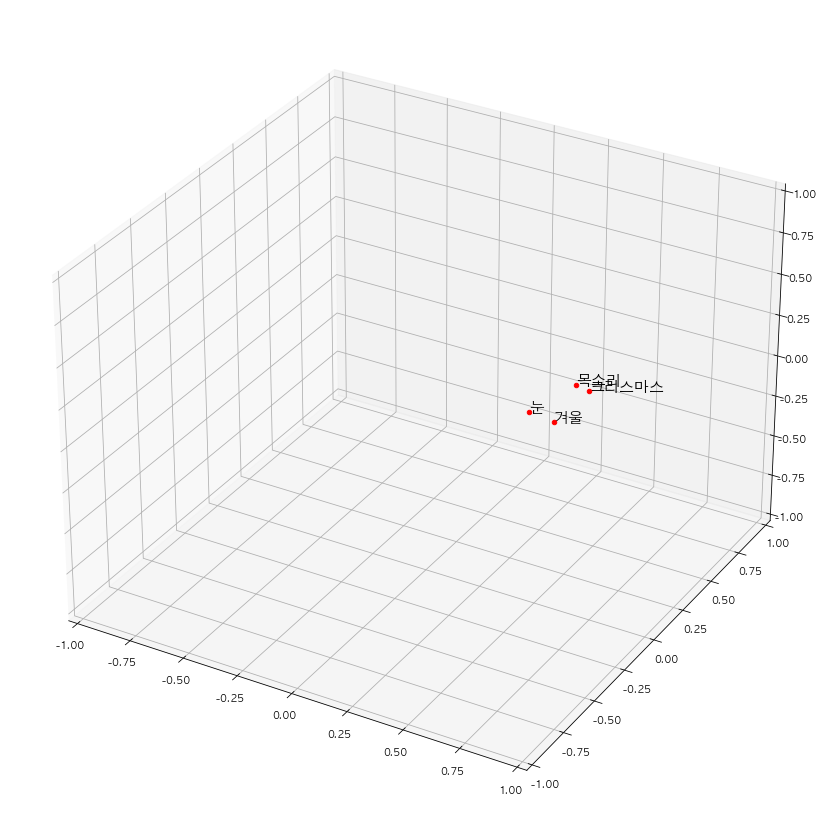

In [74]:
labels = ['목소리', '겨울', '크리스마스', '눈']
fig = plt.figure(figsize=(15, 15))
ax = fig.gca(projection='3d')
ax.set_xlim3d(-1, 1)
ax.set_ylim3d(-1, 1)
ax.set_zlim3d(-1, 1)

ax.scatter(voice[0], voice[1], voice[2], color='red')
ax.scatter(winter[0], winter[1], winter[2], color='red')
ax.scatter(christmas[0], christmas[1], christmas[2], color='red')
ax.scatter(snow[0], snow[1], snow[2], color='red')
ax.text(voice[0], voice[1], voice[2], '목소리', size=15)
ax.text(winter[0], winter[1], winter[2], '겨울', size=15)
ax.text(christmas[0], christmas[1], christmas[2], '크리스마스', size=15)
ax.text(snow[0], snow[1], snow[2], '눈', size=15)
    
plt.show()

### 시각화 방법 2. Word2Vec 을 이용해 토크나이징해서, 유사도 점수가 TOP 20 인 단어 중, 감정단어를 뽑아서 계산 
Word2Vec-전체 댓글 중 유사도가 높았던 감정단어로 계산